<a href="https://colab.research.google.com/github/yonitsur/Compiler/blob/main/waste_segmentation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="0-2"></a>
### Choose the GPU Runtime
- Make sure your runtime is **GPU**. You can select in settings by going to `Runtime -> Change runtime type -> Select a GPU and then press SAVE`

In [1]:
import matplotlib.pyplot as plt
import cv2
import yaml
import os
import torch
import copy
from PIL import Image
from torchvision import transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from tqdm import tqdm
from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import sys
import numpy as np
import skimage.feature as feature
import torch.nn.functional as F
import random
import json


print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.7.1+cu128
Torchvision version: 0.22.1+cu128
CUDA is available: True


In [2]:
reverse_labels_dict = {
    0: 'Metal',
    1: 'Wood',
    2: 'Carton+Paper',
    3: 'Rigid polymers',
    4: 'Flexible polymers',
    5: 'Mineral',
    # 6:'Rubber',
    6: 'Background',
    7: 'Other'
}

labels_colors = {
    'Metal': (0.1, 0.1, 0.1),
    # 'Metal': (1, 1, 1),
    'Wood': (1, 1, 0),
    'Carton+Paper': (0.5, 0.2, 0),
    'Rigid polymers': (1, 0, 0),
    'Flexible polymers': (1, 0, 0.8),
    'Mineral': (1, 0.63, 0),
    'Background': (0, 1, 0),
    # 'Background': (0, 0, 0),
    'Other': (0.5, 0, 1),
    # 'Rubber':(1, 0, 1)
}

NORMALIZE = True

MIN_MASK_SIZE = 2000






## Download SAM

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
np.random.seed(3)
color_mask = np.concatenate([np.random.random(3), [0.5]])

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [5]:
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# from segment_anything.utils.amg import *
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# from segment_anything.utils.amg import *

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"
# device = "cuda"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.utils.amg import rle_to_mask, mask_to_rle_pytorch

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=2000.0,
    use_m2m=True,
    output_mode="uncompressed_rle",
)
# image = Image.open('C:/Users/yonit/Yoni/SAM2/sam2/data/DJI_20230629093753_0210_V/split_15/split_15.jpg')
# image = np.array(image.convert("RGB"))



In [6]:
original_model = resnet50(weights=ResNet50_Weights.DEFAULT)
weights = ResNet50_Weights.DEFAULT

class Altered(nn.Module):
    def __init__(self):
        super(Altered, self).__init__()
        for param in original_model.parameters():
            param.requires_grad = False
        num_ftrs = original_model.fc.in_features
        original_model.fc = nn.Linear(num_ftrs, 256)
        self.resnet = original_model.cuda()
        self.relu = nn.ReLU(inplace=True)
        self.fc_1 = nn.Linear(256, len(reverse_labels_dict)).cuda()

    def forward(self, x):
        im, feat = x
        out = self.resnet(im)
        out = self.relu(out)
        out1 = self.fc_1(out)
        out = out1
        return out

model = Altered()

criterion = nn.CrossEntropyLoss(torch.Tensor([30,8,5,4,4,900,4,30])) #reweight the loss such that each class has equal contribution to the loss

optimizer_conv = optim.SGD([{'params': model.resnet.fc.parameters()}, {'params': model.fc_1.parameters()}
                            ], lr=0.05, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.5)

model_transfered = model

model_transfered = torch.load(
    "../checkpoints/transfered_resnet_split_weighted_no_rubber_gezer_all_data_lr_0.05_wd_0.001_momentum_0.9.pkl", 
    weights_only=False)
model_transfered.eval()

Altered(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
def split_image(image, num_rows, num_cols):
    height, width = image.shape[:2]
    split_height = height // num_rows
    split_width = width // num_cols
    splits = []
    for r in range(num_rows):
        for c in range(num_cols):
            split = image[r * split_height:(r + 1) * split_height, c * split_width:(c + 1) * split_width]
            splits.append(split)
    return splits


def crop_object(image, mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    contour_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.drawContours(contour_mask, [largest_contour], 0, 255, -1)
    cropped_image = cv2.bitwise_and(image, image, mask=contour_mask.T)
    max_x = max([largest_contour[i][0][1] for i in range(largest_contour.shape[0])])
    min_x = min([largest_contour[i][0][1] for i in range(largest_contour.shape[0])])
    max_y = max([largest_contour[i][0][0] for i in range(largest_contour.shape[0])])
    min_y = min([largest_contour[i][0][0] for i in range(largest_contour.shape[0])])
    return cropped_image, [int(min_x), int(min_y), int(max_x), int(max_y)]


def get_texture_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    graycom = feature.graycomatrix(gray, [1], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], levels=256)
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')

    feat = np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
    mean = feat.mean(axis=1).reshape(-1, 1)
    std = feat.std(axis=1).reshape(-1, 1)
    feat = (feat - mean) / std

    return feat.flatten().tolist()

def create_data(folder_path, image_name):
    _dict = {}
    print(f"****** {image_name} ******")
    im_path = os.path.join(folder_path, image_name, f"{image_name}.jpg")
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # if not os.path.exists(im_path):
    #     os.makedirs(im_path)
    # cv2.imwrite(f'{im_path}/{image_name}.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    splits = split_image(img, 4, 4)
    _dict[image_name] = {}
    bm = []
    for sp in tqdm(range(1, len(splits)+1)):
        split_path = f"{folder_path}/{image_name}/split_{sp}"
        if not os.path.exists(split_path):
            os.makedirs(split_path)
        image = splits[sp-1]
        cv2.imwrite(f'{split_path}/split_{sp}.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        masks = mask_generator.generate(image)
        _dict[image_name][f"split_{sp}"] = {}
        covered_area = np.zeros((image.shape[0], image.shape[1]))
        
        mask_idx = 1
        for i in range(len(masks)):
            mask = masks[i]['segmentation']
            f_mask = rle_to_mask(mask).T
            covered_area += f_mask.T.astype(np.int32)
            if masks[i]['area'] > MIN_MASK_SIZE:
                cropped_image, box = crop_object(image, f_mask)
                cropped_image = cropped_image[box[1]:box[3], box[0]:box[2]]
                cv2.imwrite(f'{split_path}/mask_{mask_idx}.jpg', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                # _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}'] = masks[i]
                _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}'] = {}
                _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}']["box"] = masks[i]["crop_box"]
                _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}']["bbox"] = box
                _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}']['textures'] = get_texture_features(cropped_image)
                _dict[image_name][f"split_{sp}"][f'mask_{mask_idx}']["label"] = "Unknown"
                mask_idx += 1
        # uncovered = copy.deepcopy(image)
        # uncovered[np.where(covered_area.astype(bool))] = 0
        # uncovered[np.where(1 - covered_area.astype(bool))] = 255

        # gray_image = cv2.cvtColor(uncovered, cv2.COLOR_BGR2GRAY)
        # _, binary_mask = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
        # boolean_mask = binary_mask.astype(bool)
        # bm.append(boolean_mask)
        # height, width = boolean_mask.shape

        # for row in range(8):
        #     for col in range(8):
        #         art_mask = np.zeros_like(boolean_mask)
        #         art_mask[row * height // 8:(row + 1) * height // 8,
        #         col * width // 8:(col + 1) * width // 8] = boolean_mask[row * height // 8:(row + 1) * height // 8,
        #                                                    col * width // 8:(col + 1) * width // 8]
        #         if np.sum(art_mask) > MIN_MASK_SIZE:
        #             cropped_image, box = crop_object(image, art_mask.T.copy())
        #             cropped_image = cropped_image[box[1]:box[3], box[0]:box[2]]
        #             index = row * 8 + col
        #             cv2.imwrite(f'{split_path}/art_mask_{index}.jpg', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
        #             _dict[image_name][f"split_{sp}"][f'art_mask_{index}'] = {}
        #             _dict[image_name][f"split_{sp}"][f'art_mask_{index}']['segmentation'] = \
        #                 mask_to_rle_pytorch(torch.Tensor(art_mask).to(bool).unsqueeze(0))[0]
        #             _dict[image_name][f"split_{sp}"][f'art_mask_{index}']['area'] = int(np.sum(art_mask))
        #             _dict[image_name][f"split_{sp}"][f'art_mask_{index}']['textures'] = get_texture_features(cropped_image)

    # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    # for i in range(4):
    #     for j in range(4):
    #         axs[i, j].imshow(bm[i * 4 + j])
    #         axs[i, j].axis('off')
    # plt.show()
    ret = {image_name: _dict[image_name]}
    

    return ret



def show_anns_(image, anns, predicted,cat):
    if len(anns) == 0:
        return
    anns=list({x:anns[x] for x in predicted}.values())
    predicted = list(predicted.values())
    zipped_lists = zip(anns, predicted)
    sorted_pairs = sorted(zipped_lists, key=(lambda x: x[0]['area']), reverse=True)
    anns_sorted, predicted_sorted = zip(*sorted_pairs)
    anns = list(anns_sorted)
    predicted = list(predicted_sorted)
    polygons = []
    color = []
    z= zip(anns, predicted)

    for ann, label in zip(anns_sorted, predicted_sorted):
        m = rle_to_mask(ann['segmentation'])
        if label in ['', 'Unknown', 'Rubber']:
          continue
        color_mask = labels_colors[label]
        mask_overlay = np.ones(image.shape, dtype=np.uint8)
        for i in range(3):
            mask_overlay[:, :, i] = color_mask[i]*255
        where_mask = m.astype(bool)
        image[where_mask] = cv2.addWeighted(image, 0.4, mask_overlay, 0.6, 0)[where_mask]
    return image


def plot_image(predictions_array, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = img.transpose((1, 2, 0))
  if NORMALIZE:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  predicted_label = np.argmax(predictions_array)
  plt.xlabel("{} {:2.0f}%".format(reverse_labels_dict[predicted_label],
                                100*np.max(predictions_array)))

def plot_value_array(predictions_array):
  plt.grid(False)
  plt.xticks(range(len(predictions_array)), list(reverse_labels_dict.values()) , rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="grey")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color(labels_colors[reverse_labels_dict[predicted_label]])


In [8]:
folder_path = "../data"
image_name="DJI_20230629093753_0210_V"

seg = create_data(folder_path, image_name)
# with open(f'{folder_path}/{file_path.split(".")[0]}/seg.yaml') as f:
#   seg = yaml.safe_load(f)

****** DJI_20230629093753_0210_V ******


  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\yonit\Yoni\image-tagging-app\venv\Lib\site-packages\sam2\sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (c:\Users\yonit\Yoni\image-tagging-app\venv\Lib\site-packages\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(
  6%|▋         | 1/16 [01:05<16:28, 65.90s/it]c:\Users\yonit\Yoni\image-tagging-app\venv\Lib\site-packages\sam2\sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (c:\Users\yonit\Yoni\image-tagging-app\venv\Lib\site-packages\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, al

In [9]:
with open(f"{folder_path}/{image_name}/seg.yaml", 'w') as f:
        yaml.dump(seg, f)
    # dump to json 
with open(f"{folder_path}/{image_name}/seg.json", 'w') as f:
        json.dump(seg, f, indent=4)

In [26]:
image_name

'DJI_20230629093753_0210_V/split_1'

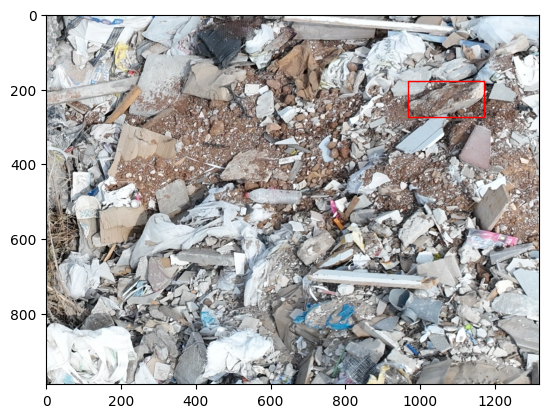

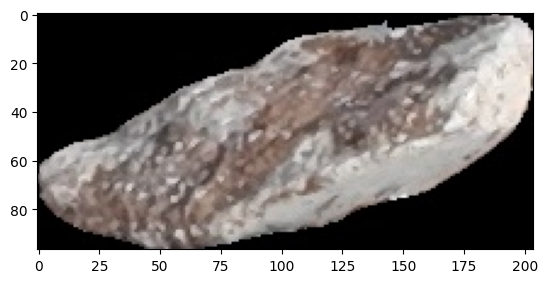

In [ ]:
# show split 1 image and the bbox of mask 1 on the split image
folder_path = "../data"
image_name="DJI_20230629093753_0210_V"
sp_num = 7
mask_num = 1

split1 = cv2.imread(f"{folder_path}/{image_name}/split_{sp_num}/split_{sp_num}.jpg")

split1 = cv2.cvtColor(split1, cv2.COLOR_BGR2RGB)

bbox = seg[image_name][f'split_{sp_num}'][f'mask_{mask_num}']['bbox']
plt.imshow(split1)
plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none'))
plt.show()

# show mask 1 image
mask1 = cv2.imread(f"{folder_path}/{image_name}/split_{sp_num}/mask_{mask_num}.jpg")
mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
plt.imshow(mask1)
plt.show()




In [10]:

def process_image(im_name, spl,cat=None):
  correct_counter = 0
  total_counter = 0
  z_outputs=[]
  z_inputs=[]
  color_images= []
  for sp in  tqdm(range(1, spl+1)[:3]):

        predicted = {}
        for m in seg[im_name][f"split_{sp}"].items():
          m_name, lab = m
          inputs, feat = process_mask(im_name, sp, m_name)
          outputs = model_transfered((inputs.unsqueeze(0).cuda(), feat))
          _, preds = torch.max(outputs, 1)
          predicted[m_name] = reverse_labels_dict[preds[0].item()]
          z_outputs.append(outputs)
          z_inputs.append(inputs)


        img = cv2.imread(f'{folder_path}/{im_name}/split_{sp}/split_{sp}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        masks = seg[im_name][sp]
        colors = labels_colors
        categories = list(colors.keys())
        values = np.linspace(0, 1, len(categories))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not os.path.exists(f"{folder_path}/output"):
          os.makedirs(f"{folder_path}/output")


        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        cmap = plt.cm.colors.ListedColormap([colors[category] for category in categories])
        norm = plt.cm.colors.Normalize(vmin=0, vmax=len(categories)-1)
        categories = list(colors.keys())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])


        spec = plt.GridSpec(1, 2, width_ratios=[20,20])  # Adjust ratios as needed
        fig = plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
        ax1 = fig.add_subplot(spec[0])
        ax1.imshow(img)
        ax1.axis('off')
        # original_img = cv2.imread(f'{folder_path}/{im_name}/split_{sp}/split_{sp}.jpg')

        ax2 = fig.add_subplot(spec[1])
        if predicted!={}:
          original_img = show_anns_(img, masks, predicted, cat)
          ax2.axis('off')

        ax2.imshow(original_img)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        color_images.append(original_img)
        cv2.imwrite(f"{folder_path}/output/here{sp}.jpg", original_img)
        handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[cat], markersize=13) for cat in categories]
        legend = ax2.legend(handles, categories, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.tight_layout()
        plt.show()

  return z_outputs,z_inputs,color_images


def process_mask(image_name, sp, mask):
  mask_im = cv2.imread(f'{folder_path}/{image_name}/split_{sp}/{mask}.jpg')
  feat = torch.Tensor(seg[image_name][sp][mask]['textures'])
  img = cv2.cvtColor(mask_im, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(img)

  if (seg[image_name][sp][mask]['area']/(im_pil.size[0]*im_pil.size[1]))<0.4:
    best_coverage = 0
    best_img = im_pil
    for _ in [15,30,45,60,75,90]:
      im_pil = im_pil.rotate(_, Image.NEAREST, expand=1)
      image = im_pil
      image_array = np.array(image)
      lower_threshold = np.array([20, 20, 20])  # Minimum color values
      upper_threshold = np.array([255, 255, 255])  # Maximum color values
      binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
      object_pixels = np.where(binary_mask)

      min_y, min_x = np.min(object_pixels, axis=1)
      max_y, max_x = np.max(object_pixels, axis=1)
      coverage = np.sum(binary_mask)/((max_x-min_x)*(max_y-min_y))

      im_pil=im_pil.crop((min_x,min_y,max_x,max_y))
      if(coverage>best_coverage):
        best_coverage = coverage
        best_img = im_pil
      im_pil = im_pil.rotate(-_, Image.NEAREST, expand=1)

    im_pil = best_img

  preprocess1 = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess1(im_pil)
  return input_tensor, feat

In [11]:
z_outputs, z_inputs, color_images = process_image(image_name, 16)

  0%|          | 0/3 [00:00<?, ?it/s]


KeyError: 1

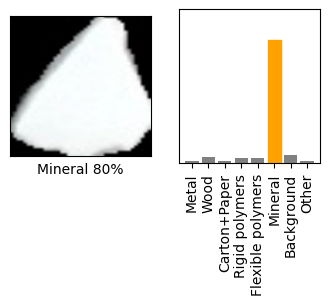

In [ ]:
number_of_images=1
for i in random.sample(range(len(z_outputs)), number_of_images):
  softmax_z_outputs_i = F.softmax(z_outputs[i], dim=1)[0]
  plt.figure(figsize=(4,2))
  plt.subplot(1,2,1)
  plot_image(softmax_z_outputs_i.cpu().detach().numpy(), z_inputs[i].cpu().detach().numpy())
  plt.subplot(1,2,2)
  plot_value_array(softmax_z_outputs_i.cpu().detach().numpy())
  plt.show()

In [ ]:
small_images = [cv2.imread(f"{folder_path}/output/here{i}.jpg") for i in range(16)]
rows, cols, _ = small_images[0].shape
big_rows = []
for i in range(0, 16, 4):
    big_row = np.hstack([small_images[i], small_images[i+1], small_images[i+2], small_images[i+3]])
    big_rows.append(big_row)

big_image = np.vstack(big_rows)
cv2.imwrite(f"{folder_path}/output/big_image.jpg", big_image)


True

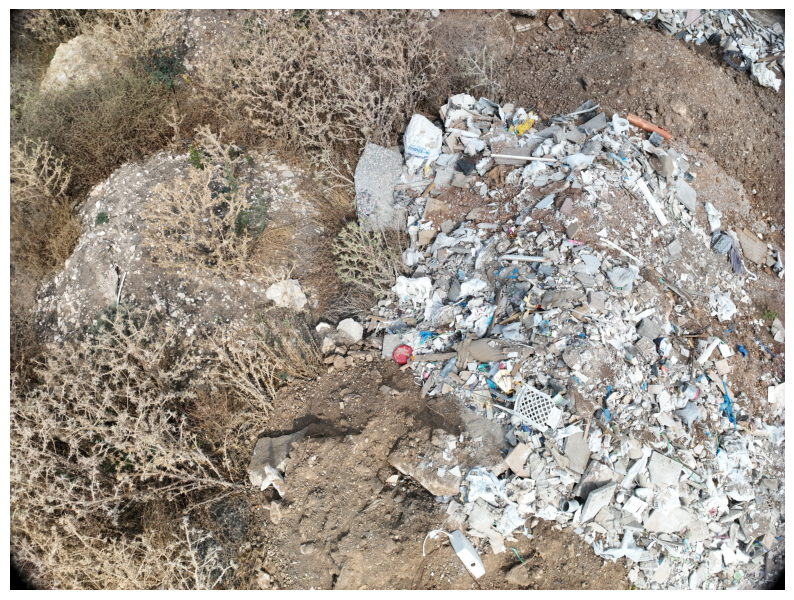

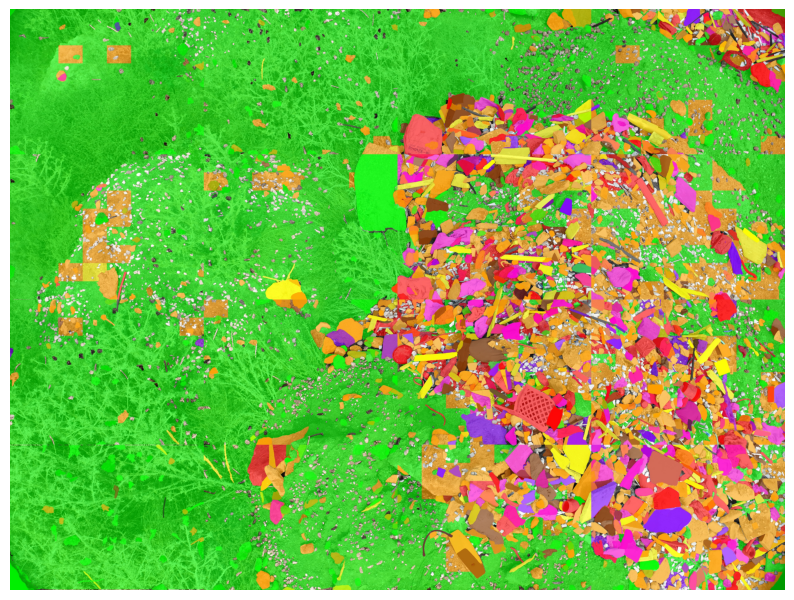

In [ ]:
plt.figure(figsize=(10, 10))
original_img = cv2.imread(file_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

plt.imshow(original_img)
plt.axis('off')
plt.show()

big_image = cv2.imread(f"{folder_path}/output/big_image.jpg")
big_image = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(big_image)
plt.axis('off')
plt.show()